# NST 
Generando imágenes con distintos niveles de detalle en el estilo. En concreto se usan los 5 niveles "clásicos" de menos profundidad a mas profundidad. Los niveles se van acumulando. Además se normalizan los pesos del estilo y del contenido para que sean selecionables. 

In [1]:
import tensorflow as tf
import numpy as np
import random
import os
import matplotlib.pyplot as plt

import PIL.Image
import timeit

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Construir modelo 

In [2]:
STYLE_WEIGHT = 100
CONTENT_WEIGHT = 0.5
Nepochs = 20000
muestra_cada = 200
Imsize = 286

In [3]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model
  

def gram_matrix(input_tensor):
    result = tf.math.reduce_mean(input_tensor, [1,2])
    #input_shape = tf.shape(input_tensor)
    #num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result#/(num_locations)

# Extraer estilo y contenido
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


# Función de pérdidas
def style_content_loss(outputs,style_weight,content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    #style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
    #                       for name in style_outputs.keys()])
    #style_loss *= style_weight 

    style_loss = [style_weight*tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()]

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight 
    loss = style_loss + content_loss
    
    return loss, style_loss, content_loss


def clip_0_1(image):
      return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [4]:
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)

style_layers_ori = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

content_layers = ['block5_conv2'] 

# Inicialización

In [5]:
path_GTA = "/content/drive/MyDrive/GTA/"
path_Reales = "/content/drive/MyDrive/Reales/"
# path_CARLA = "/content/drive/MyDrive/Simulaciones/"

iter = 10  # Número de imagenes de prueba

list_GTA = os.listdir(path_GTA)
images_GTA = random.choices(list_GTA, k=iter)

# list_CARLA = os.listdir(path_CARLA)
# images_CARLA = random.choices(list_CARLA, k=iter)

list_Reales = os.listdir(path_Reales)
images_Reales = random.choices(list_Reales, k=iter)

for i in range(iter):
  images_GTA[i] = path_GTA + images_GTA[i]
  # images_CARLA[i] = path_CARLA + images_CARLA[i]
  images_Reales[i] = path_Reales + images_Reales[i]

## Que fotos he escogido

In [ ]:
for name in images_GTA:
  print(name.split("/")[-1])
print("------------------------------------------------")
for name in images_Reales:
  print(name.split("/")[-1])

02351.png
01685.png
01857.png
02298.png
01389.png
02139.png
01103.png
01772.png
01282.png
01322.png
------------------------------------------------
strasbourg_000001_016376_leftImg8bit.png
hamburg_000000_046078_leftImg8bit.png
hamburg_000000_069289_leftImg8bit.png
bremen_000263_000019_leftImg8bit.png
dusseldorf_000144_000019_leftImg8bit.png
monchengladbach_000000_026908_leftImg8bit.png
cologne_000002_000019_leftImg8bit.png
jena_000110_000019_leftImg8bit.png
hamburg_000000_105296_leftImg8bit.png
bremen_000207_000019_leftImg8bit.png


## Ajustes imagen

In [6]:
style_image = PIL.Image.open(images_Reales[0])
content_image = PIL.Image.open(images_GTA[0])

content_image = np.asarray(content_image.resize((Imsize,Imsize)))
style_image = np.asarray(style_image.resize((Imsize,Imsize)))

content_image = content_image[:,:,0:3].astype(np.float32)/255
style_image = style_image[:,:,0:3].astype(np.float32)/255

content_image = np.expand_dims(content_image,0)
style_image = np.expand_dims(style_image,0)

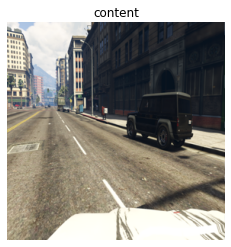

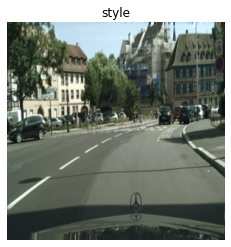

In [7]:
plt.figure()
plt.imshow(content_image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.title('content')
plt.show()

plt.figure()
plt.imshow(style_image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.title('style')
plt.show()

# BUCLE

Testing the statistics size

In [ ]:
STYLE_WEIGHT = 1000  # Modificable

for layer in np.arange(1,2):#6):

    style_layers = style_layers_ori[0:5]#layer]

    extractor = StyleContentModel(style_layers, content_layers)
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']

    #image = tf.Variable(content_image.copy())
    image = tf.Variable(content_image.copy())

    # WEIGHTS FIRST GUESS
    style_weight_FG=5*1e-11
    content_weight_FG=1e-4

    loss, style_loss, content_loss = style_content_loss(extractor(content_image),style_weight_FG,content_weight_FG)
    # print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))
    loss_style = np.array(style_loss[0])

    loss, style_loss, content_loss = style_content_loss(extractor(style_image),style_weight_FG,content_weight_FG)
    # print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))
    loss_content = np.array(content_loss)

    # WEIGTHS DEFINITION
    style_weight= style_weight_FG * STYLE_WEIGHT/loss_style
    content_weight= content_weight_FG * CONTENT_WEIGHT/loss_content

    # Certify Weights
    loss, style_loss, content_loss = style_content_loss(extractor(content_image),style_weight,content_weight)
    # print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))

    loss, style_loss, content_loss = style_content_loss(extractor(style_image),style_weight,content_weight)
    # print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))

    @tf.function()  # Precompile
    def train_step(image):
        with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_content_loss(outputs,style_weight,content_weight)

        grad = tape.gradient(loss[1][0], image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))

    L_cont = np.array([])
    L_style = np.array([]) 

    start = timeit.default_timer()
    for n in range(0,Nepochs):
        train_step(image)
        
        if np.mod(n,muestra_cada)==0:
            outputs = extractor(image)
            loss, style_loss, content_loss = style_content_loss(outputs,style_weight,content_weight)
            
            L_cont = np.append(L_cont,np.array(content_loss))
            L_style = np.append(L_style,np.array(style_loss[0]))

            # print(layer, n, np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))
            
            stop = timeit.default_timer()
            print("Epoch:", n, 'Time: ', stop - start) 

    # RESULTS
    # Curvas
    # plt.figure()
    # plt.plot(np.log(L_cont))
    # plt.plot(np.log(L_style))
    # plt.show()

    # Resultados
    plt.figure()
    plt.imshow(image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
    plt.savefig("/content/drive/MyDrive/Resultados/AA_NST_1000.png", bbox_inches="tight", pad_inches=0)

    # Keep track
    # print('style_weight: ' + str(style_weight) + ' content_weight: ' + str(content_weight))
    # print(style_layers)

In [ ]:
plt.figure()
plt.imshow(content_image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.title('content')
plt.show()
plt.figure()
plt.imshow(image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
# plt.title('image')
plt.show()

In [ ]:
# Curvas
plt.figure()
# plt.plot(np.log(L_cont[20:]))
plt.plot(np.log(L_style[0:]))
plt.show()

# Segmentación

## Ajustes

In [25]:
def one_hot_mask(y):
    ''' Do the one hot encoding for the masks.
  
    Arguments:
        - y (tf tensor): Mask of shape (height, width, 3)

    Returns:
        - mask (tf tensor): Mask after do the one hot. Shape (height, width, num_classes) '''

    one_hot_map = []
    for color in colors:
        class_map = tf.reduce_all(tf.equal(y, color), axis = -1)
        one_hot_map.append(class_map)
    mask = tf.cast(tf.stack(one_hot_map, axis = -1), tf.int32)
    return mask


def load_image(folder, file, height = 96, width = 256, crop = False):
    ''' Load and preprocess a train image by:
        - Crop the image to not have the Mercedes-Benz star
        - Resize the image to (height, width)
        - Normalize the image to [0, 1]
  
    Arguments:
        - folder (string): Path to the folder
        - file (string): Name of the file to load
        - height (int): Height to resize -- 96
        - width (int): Width to resize -- 256
        - crop (bool): Crpo the image or not -- True

    Returns:
        - image (tf tensor): Preprocessed image '''

    # Load the image (png)
    image = tf.io.read_file(folder + '/' + file)
    image = tf.cast(tf.image.decode_png(image, channels = 3), tf.float32)

    # Crop the image
    if crop:
        image = tf.image.crop_to_bounding_box(image, 0, 0, 768, 2048)

    # Resize the image
    image = tf.image.resize(image, (height, width))

    # Normalize the image
    image = tf.cast(image, tf.float32)/255.0
    return image


def load_mask(folder, file, height = 96, width = 256, one_hot = True, crop = False):
    ''' Load and preprocess a train mask by:
        - Crop the image to not have the Mercedes-Benz star
        - Resize the image to (height, width)
        - Reshaping the mask from (height, width, 3) to (height, width, 30): One hot encoding
  
    Arguments:
        - folder (string): Path to the folder
        - file (string): Name of the file to load
        - height (int): Height to resize -- 96
        - width (int): Width to resize -- 256
        - one_hot (bool): Do one hot encoding or not -- True
        - crop (bool): Crpo the image or not -- True

    Returns:
        - image (tf tensor): Preprocessed mask '''

    # Load the mask (png)
    image = tf.io.read_file(folder + '/' + file)
    image = tf.cast(tf.image.decode_png(image, channels = 3), tf.int32)

    # Crop the mask
    if crop:
        image = tf.image.crop_to_bounding_box(image, 0, 0, 768, 2048)

    # Resize the mask
    image = tf.image.resize(image, (height, width), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # One hot encoding
    if one_hot:
        image = one_hot_mask(image)
    return image


def one_hot_to_color_mask(mask, colors, img_height = 96, img_width = 256):
    ''' Convert from the mask from the classes with highest probablities to the correct color. From (96, 256, 1) to (96, 256, 3).
  
    Arguments:
        - mask (tf tensor): Mask with the classes with highest probabilities
        - colors (list): List with the class colors
        - img_height (int): Height of the images -- 96
        - img_width (int): Width of the images -- 256

    Returns:
        - color_mask (tf tensor): Color mask '''

    color_mask = np.zeros((img_height, img_width, channels)).astype('float')
    for c in range(len(colors)):
        color_true = mask == c
        for i in range(3):
            color_mask[:,:,i] += color_true*colors[c][i]

    color_mask = tf.cast(color_mask, dtype = tf.int32)

    return color_mask

def load_train(image_name, mask_name):
    ''' Load and preprocess a train image and its mask
  
    Arguments:
        - image_name (string): Name of the image to load
        - mask_name (string): Name of the mask to load

    Returns:
        - image (tf tensor): Preprocessed image
        - mask (tf tensor): Preprocessed mask '''

    image = load_image(train_images_folder_path, image_name, img_height, img_width)
    mask = load_mask(train_mask_folder_path, mask_name, img_height, img_width)
    return image, mask

In [26]:
train_images_folder_path = "/content/drive/My Drive" 
train_mask_folder_path = "/content/drive/MyDrive/GTA Segmentacion" 

img_height, img_width, channels = 96, 256, 3

batch_size = 2

colors = np.array([(0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (250, 170, 160), (230, 150, 140), (70, 70, 70), (102, 102, 156), (190, 153, 153), (180, 165, 180), 
                   (150, 100, 100), (150, 120, 90), (153, 153, 153), (250, 170, 30), (220, 220, 0), (107, 142, 35), (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0), ( 0, 0, 142), 
                   ( 0, 0, 70), (0, 60, 100), (0, 0, 90), (0, 0, 110), (0, 80, 100), (0, 0, 230), (119, 11, 32), (0, 0, 142)], dtype = np.int32)

model = tf.keras.models.load_model('/content/drive/My Drive/Modelo_segmentacion_UNET/best_model_weights_and_architecture')

## La magia

2/2 [==============================] - 1s 188ms/step


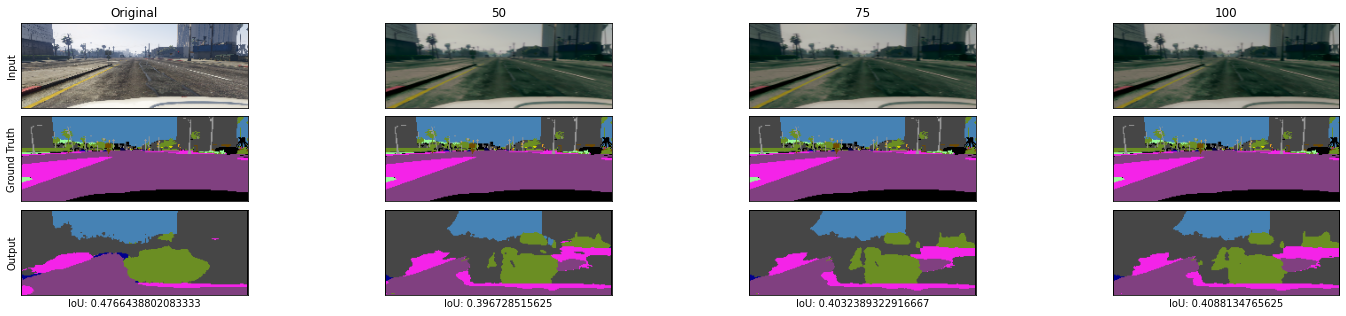

In [ ]:
# Visualización final
images_name = ["GTA/" + images_GTA[0].split("/")[-1], "Resultados/AA_NST_50.png", "Resultados/AA_NST_75.png", "Resultados/AA_NST_100.png"]

mask_names = ((images_GTA[0].split("/")[-1] + " ") * 4).split()

dataset = tf.data.Dataset.from_tensor_slices((images_name, mask_names))
dataset = dataset.map(load_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(batch_size)


predictions = model.predict(dataset, batch_size = 10)
predictions = np.argmax(predictions, axis = 3)

idx = range(len(images_name))
visualize_images = [load_image(train_images_folder_path, images_name[i], img_height, img_width) for i in idx]
visualize_masks = [load_mask(train_mask_folder_path, mask_names[i], img_height, img_width, one_hot = False) for i in idx]
preds = predictions[idx]

iou_score = []
iou_score_half = []

# Resultados GTA
plt.figure(figsize = (16, 4))
plt.subplots_adjust(hspace = 0.1)

for k in range(4):
    plt.subplot(3, 4, k + 1)
    plt.imshow(visualize_images[k])
    if k==0:
      plt.ylabel("Input")
    plt.title(["Original", "50", "75", "100"][k])
    plt.yticks(())
    plt.xticks(())

    plt.subplot(3, 4, k + 5)
    plt.imshow(visualize_masks[k])
    if k==0:
      plt.ylabel("Ground Truth")
    plt.yticks(())
    plt.xticks(())

    output = one_hot_to_color_mask(preds[k], colors)
    # IoU calculation
    intersection = 0
    union = img_height * img_width

    for i in range(img_height):
      for j in range(img_width):
        a = visualize_masks[k][i-1,j-1,:] == output[i-1,j-1,:]
        if sum(a.numpy())==3:
          intersection += 1

    iou_score.append(intersection/union)

# Calcula de la mitad hacia abajo
    intersection = 0
    union = int(img_height/2) * img_width

    for i in range(int(img_height/2), img_height):
        for j in range(img_width):
          a = visualize_masks[k][i-1,j-1,:] == output[i-1,j-1,:]
          if sum(a.numpy())==3:
            intersection += 1

    iou_score_half.append(intersection/union)

    plt.subplot(3, 4, k + 9)
    plt.imshow(output)
    if k==0:
      plt.ylabel("Output")
    plt.xlabel("IoU: %s" % iou_score[k])
    plt.yticks(())
    plt.xticks(())

plt.savefig("/content/drive/MyDrive/Resultados/A_NSTs_1.png", bbox_inches="tight", pad_inches=0)

2/2 [==============================] - 1s 186ms/step


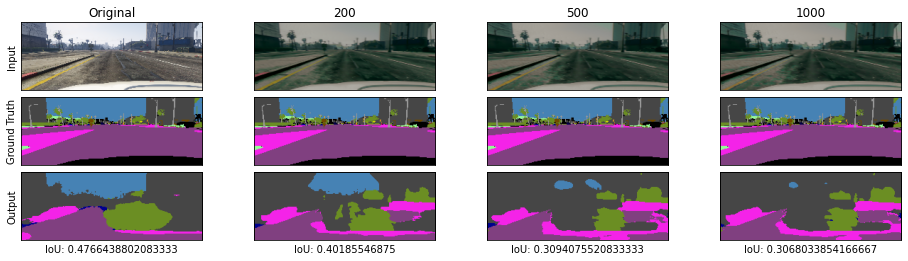

In [ ]:
# Visualización final
images_name = ["GTA/" + images_GTA[0].split("/")[-1], "Resultados/AA_NST_200.png", "Resultados/AA_NST_500.png", "Resultados/AA_NST_1000.png"]


dataset = tf.data.Dataset.from_tensor_slices((images_name, mask_names))
dataset = dataset.map(load_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(batch_size)


predictions = model.predict(dataset, batch_size = 10)
predictions = np.argmax(predictions, axis = 3)

idx = range(len(images_name))
visualize_images = [load_image(train_images_folder_path, images_name[i], img_height, img_width) for i in idx]
preds = predictions[idx]


# Resultados GTA
plt.figure(figsize = (16, 4))
plt.subplots_adjust(hspace = 0.1)

for k in range(4):
    plt.subplot(3, 4, k + 1)
    plt.imshow(visualize_images[k])
    if k==0:
      plt.ylabel("Input")
    plt.title(["Original", "200", "500", "1000"][k])
    plt.yticks(())
    plt.xticks(())

    plt.subplot(3, 4, k + 5)
    plt.imshow(visualize_masks[k])
    if k==0:
      plt.ylabel("Ground Truth")
    plt.yticks(())
    plt.xticks(())

    output = one_hot_to_color_mask(preds[k], colors)
    # IoU calculation
    intersection = 0
    union = img_height * img_width

    for i in range(img_height):
      for j in range(img_width):
        a = visualize_masks[k][i-1,j-1,:] == output[i-1,j-1,:]
        if sum(a.numpy())==3:
          intersection += 1

    iou_score.append(intersection/union)
    
# Calcula de la mitad hacia abajo
    intersection = 0
    union = int(img_height/2) * img_width

    for i in range(int(img_height/2), img_height):
        for j in range(img_width):
          a = visualize_masks[k][i-1,j-1,:] == output[i-1,j-1,:]
          if sum(a.numpy())==3:
            intersection += 1

    iou_score_half.append(intersection/union)

    plt.subplot(3, 4, k + 9)
    plt.imshow(output)
    if k==0:
      plt.ylabel("Output")
    plt.xlabel("IoU: %s" % iou_score[k+4])
    plt.yticks(())
    plt.xticks(())

plt.savefig("/content/drive/MyDrive/Resultados/A_NSTs_2.png", bbox_inches="tight", pad_inches=0)

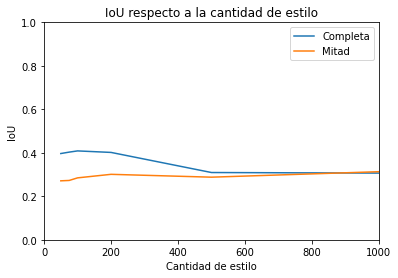

In [ ]:
n_style = [50,75,100,200,500,1000]
iou = []
iou_half = []
for i in range(len(iou_score)):
  if i not in [0,4]:
    iou.append(iou_score[i])
    iou_half.append(iou_score_half[i])

plt.figure()
plt.plot(n_style, iou, label="Completa")
plt.plot(n_style, iou_half, label="Mitad")
plt.title('IoU respecto a la cantidad de estilo')
plt.ylabel("IoU")
plt.xlabel("Cantidad de estilo")
plt.axis([0,1000,0,1])
plt.legend()
plt.savefig("/content/drive/MyDrive/Resultados/A_comparacion_NST.png", bbox_inches="tight", pad_inches=0)

# Automático para muchos

In [27]:
n_style = [50,75,100,200,500,1000]

for num in range(7, iter):

  # NST  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
  style_image = PIL.Image.open(images_Reales[num])
  content_image = PIL.Image.open(images_GTA[num])

  content_image = np.asarray(content_image.resize((Imsize,Imsize)))
  style_image = np.asarray(style_image.resize((Imsize,Imsize)))

  content_image = content_image[:,:,0:3].astype(np.float32)/255
  style_image = style_image[:,:,0:3].astype(np.float32)/255

  content_image = np.expand_dims(content_image,0)
  style_image = np.expand_dims(style_image,0)


  for s in n_style:
    STYLE_WEIGHT = s # Cambiamos la cantidad de estilo en cada irteración

    for layer in np.arange(1,2):#6):

        style_layers = style_layers_ori[0:5]#layer]

        extractor = StyleContentModel(style_layers, content_layers)
        style_targets = extractor(style_image)['style']
        content_targets = extractor(content_image)['content']

        image = tf.Variable(content_image.copy())

        # WEIGHTS FIRST GUESS
        style_weight_FG=5*1e-11
        content_weight_FG=1e-4

        loss, style_loss, content_loss = style_content_loss(extractor(content_image),style_weight_FG,content_weight_FG)
        loss_style = np.array(style_loss[0])

        loss, style_loss, content_loss = style_content_loss(extractor(style_image),style_weight_FG,content_weight_FG)
        loss_content = np.array(content_loss)

        # WEIGTHS DEFINITION
        style_weight= style_weight_FG * STYLE_WEIGHT/loss_style
        content_weight= content_weight_FG * CONTENT_WEIGHT/loss_content

        # Certify Weights
        loss, style_loss, content_loss = style_content_loss(extractor(content_image),style_weight,content_weight)

        loss, style_loss, content_loss = style_content_loss(extractor(style_image),style_weight,content_weight)

        @tf.function()  # Precompile
        def train_step(image):
            with tf.GradientTape() as tape:
                outputs = extractor(image)
                loss = style_content_loss(outputs,style_weight,content_weight)

            grad = tape.gradient(loss[1][0], image)
            opt.apply_gradients([(grad, image)])
            image.assign(clip_0_1(image))

        L_cont = np.array([])
        L_style = np.array([]) 

        for n in range(0,Nepochs):
            train_step(image)
            
            if np.mod(n,muestra_cada)==0:
                outputs = extractor(image)
                loss, style_loss, content_loss = style_content_loss(outputs,style_weight,content_weight)
                
                L_cont = np.append(L_cont,np.array(content_loss))
                L_style = np.append(L_style,np.array(style_loss[0]))

        # Resultados
        plt.figure()
        plt.imshow(image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
        plt.savefig("/content/drive/MyDrive/Resultados/AA_NST_" + str(s) + "_" + str(num+1) + ".png", bbox_inches="tight", pad_inches=0)


  # Visualización final  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
  images_name = ["GTA/" + images_GTA[0].split("/")[-1], "Resultados/AA_NST_50_" + str(num+1) + ".png", "Resultados/AA_NST_75_" + str(num+1) + ".png", "Resultados/AA_NST_100_" + str(num+1) + ".png"]

  mask_names = ((images_GTA[0].split("/")[-1] + " ") * 4).split()

  dataset = tf.data.Dataset.from_tensor_slices((images_name, mask_names))
  dataset = dataset.map(load_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)

  predictions = model.predict(dataset, batch_size = 10)
  predictions = np.argmax(predictions, axis = 3)

  idx = range(len(images_name))
  visualize_images = [load_image(train_images_folder_path, images_name[i], img_height, img_width) for i in idx]
  visualize_masks = [load_mask(train_mask_folder_path, mask_names[i], img_height, img_width, one_hot = False) for i in idx]
  preds = predictions[idx]

  iou_score = []
  iou_score_half = []

  # Resultados GTA
  plt.figure(figsize = (16, 4))
  plt.subplots_adjust(hspace = 0.1)

  for k in range(4):
      plt.subplot(3, 4, k + 1)
      plt.imshow(visualize_images[k])
      if k==0:
        plt.ylabel("Input")
      plt.title(["Original", "50", "75", "100"][k])
      plt.yticks(())
      plt.xticks(())

      plt.subplot(3, 4, k + 5)
      plt.imshow(visualize_masks[k])
      if k==0:
        plt.ylabel("Ground Truth")
      plt.yticks(())
      plt.xticks(())

      output = one_hot_to_color_mask(preds[k], colors)
      # IoU calculation
      intersection = 0
      union = img_height * img_width

      for i in range(img_height):
        for j in range(img_width):
          a = visualize_masks[k][i-1,j-1,:] == output[i-1,j-1,:]
          if sum(a.numpy())==3:
            intersection += 1

      iou_score.append(intersection/union)

  # Calcula de la mitad hacia abajo
      intersection = 0
      union = int(img_height/2) * img_width

      for i in range(int(img_height/2), img_height):
          for j in range(img_width):
            a = visualize_masks[k][i-1,j-1,:] == output[i-1,j-1,:]
            if sum(a.numpy())==3:
              intersection += 1

      iou_score_half.append(intersection/union)

      plt.subplot(3, 4, k + 9)
      plt.imshow(output)
      if k==0:
        plt.ylabel("Output")
      plt.xlabel("IoU: %s" % iou_score[k])
      plt.yticks(())
      plt.xticks(())

  plt.savefig("/content/drive/MyDrive/Resultados/A_NSTs_" + str(num+1) + "_1.png", bbox_inches="tight", pad_inches=0)

  # Visualización final 2  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
  images_name = ["GTA/" + images_GTA[0].split("/")[-1], "Resultados/AA_NST_200_" + str(num+1) + ".png", "Resultados/AA_NST_500_" + str(num+1) + ".png", "Resultados/AA_NST_1000_" + str(num+1) + ".png"]

  dataset = tf.data.Dataset.from_tensor_slices((images_name, mask_names))
  dataset = dataset.map(load_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)

  predictions = model.predict(dataset, batch_size = 10)
  predictions = np.argmax(predictions, axis = 3)

  visualize_images = [load_image(train_images_folder_path, images_name[i], img_height, img_width) for i in idx]
  preds = predictions[idx]

  plt.figure(figsize = (16, 4))
  plt.subplots_adjust(hspace = 0.1)

  for k in range(4):
      plt.subplot(3, 4, k + 1)
      plt.imshow(visualize_images[k])
      if k==0:
        plt.ylabel("Input")
      plt.title(["Original", "200", "500", "1000"][k])
      plt.yticks(())
      plt.xticks(())

      plt.subplot(3, 4, k + 5)
      plt.imshow(visualize_masks[k])
      if k==0:
        plt.ylabel("Ground Truth")
      plt.yticks(())
      plt.xticks(())

      output = one_hot_to_color_mask(preds[k], colors)
      # IoU calculation
      intersection = 0
      union = img_height * img_width

      for i in range(img_height):
        for j in range(img_width):
          a = visualize_masks[k][i-1,j-1,:] == output[i-1,j-1,:]
          if sum(a.numpy())==3:
            intersection += 1

      iou_score.append(intersection/union)
      
  # Calcula de la mitad hacia abajo
      intersection = 0
      union = int(img_height/2) * img_width

      for i in range(int(img_height/2), img_height):
          for j in range(img_width):
            a = visualize_masks[k][i-1,j-1,:] == output[i-1,j-1,:]
            if sum(a.numpy())==3:
              intersection += 1

      iou_score_half.append(intersection/union)

      plt.subplot(3, 4, k + 9)
      plt.imshow(output)
      if k==0:
        plt.ylabel("Output")
      plt.xlabel("IoU: %s" % iou_score[k+4])
      plt.yticks(())
      plt.xticks(())

  plt.savefig("/content/drive/MyDrive/Resultados/A_NSTs_" + str(num+1) + "_2.png", bbox_inches="tight", pad_inches=0)

  # Visualización final 3 &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
  iou = []
  iou_half = []
  for i in range(len(iou_score)):
    if i not in [0,4]:
      iou.append(iou_score[i])
      iou_half.append(iou_score_half[i])

  plt.figure()
  plt.plot(n_style, iou, label="Completa")
  plt.plot(n_style, iou_half, label="Mitad")
  plt.title('IoU respecto a la cantidad de estilo')
  plt.ylabel("IoU")
  plt.xlabel("Cantidad de estilo")
  plt.axis([0,1000,0,1])
  plt.legend()
  plt.savefig("/content/drive/MyDrive/Resultados/A_comparacion_NST" + str(num+1) + ".png", bbox_inches="tight", pad_inches=0)

  print("Completado el", str(num+1))

Output hidden; open in https://colab.research.google.com to view.